<h1> L3a: Regresja liniowa w podejściu Bayesowskim i nie </h1>

W ramach dzisiejszych zajęć:

1. rozważymy problem uczenia się regresji liniowej w podejściu maximum likelihood (MLE) oraz bayesowskim. 

2. użyjemy implementacji scikit-learn na tradycyjnym zbiorze cyfr MNIST

# (Szybkie) przypomnienie

Spojrzenie probabilistyczne

<img width=300 src="figures/L3/frequentists_vs_bayesians.png">

## Przypomnienie

Machine learning jako robienie ``push-up`` rozkładu prior

* P(w) - prior

* P(x | w) - likelihood

* P(w | x) - posterior

Na obrazku powyzej osoba po lewej liczy P(w=0 | x), co nie zawsze jest przydatne.

<img width=400 src="figures/L3/pavel.jpg">

### Przyklad

Źródło: http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb

[Omówienie przykładu na zajęciach]

# Regresja liniowa

Źródło: https://www.cs.ox.ac.uk/people/nando.defreitas/machinelearning/lecture3.pdf

Znamy już świetnie rozkład Gaussa. Podobnie jak w naszych eksperymentach z rzutami monetą, podejście maximum likelihood jest relatywnie proste.

Załóżmy, że dane pochodzą rozkładu normalnego, czyli podobnie jak w przypadku rzutu monetą zakładamy, że:

$$ p(y | x) = N(<x, w>, \sigma^2) = <x, w> + N(0, \sigma^2) $$


## Funkcje bazowe

Nic więcej poza nową reprezentacją.

 $y(\mathbf{x},\mathbf{w}) = \sum_{j=0}^{M-1} w_j\phi_j(\mathbf{x}) = \mathbf{w}^T\mathbf{\phi}(\mathbf{x})$
 
 , gdzie $\phi(\mathbf{x}) = \\{\phi_0(\mathbf{x}),\phi_1(\mathbf{x}), \ldots,\phi_{M-1}(\mathbf{x})\\}$

## Estymator MLE


$$ \theta^* = argmax \prod_i p(y_i | x_i) $$

$\theta^* = \left(\mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{t}$ <br/><br/>

[Wyprowadzenie na tablicy wzoru na estymator MLE, https://www.cs.ox.ac.uk/people/nando.defreitas/machinelearning/lecture3.pdf. Uwaga! To może być na egzaminie]

In [6]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Cwiczenie 1 (3 pkt) - Kernelized Linear Regression

Dane pochodzą z rozkładu y_i = m*x_i + b + N(0, 1). 

Na podstawie 101 przykładów z rozkładu policz estymator MLE następującego modelu:

a) $$ p(y | x) = N(<x, w> + b, \sigma^2) = <x, w> + b + N(0, \sigma^2) $$. Równoważne $\phi(x) = [1, x]$ (patrz podpunkt b)

b) $$ p(y | x) = N(<\phi(x), w>, \sigma^2) = <\phi(x), w> + N(0, \sigma^2) $$, gdzie $\phi(x) = [1, x, x^2, x^3, x^4]$

Kod powinien być opakowany w klase ToyLinearRegression z metodami fit oraz predict. ToyLinearRegression powinien przyjmować w konstruktorze funkcję phi, która zamienia x na jego cechy, np phi(x) = [x] oznacza liniowy model.

In [ ]:
from sklearn.linear_model import LinearRegression

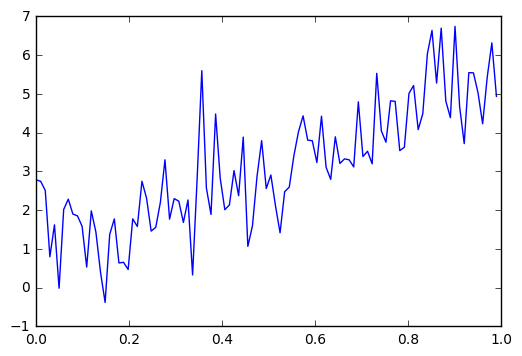

In [7]:
## Syntetyczny zbiór danych z dużym szumem ale liniowymi danymi
np.random.seed(123456789)

def y(x,m,b,mu=0,sigma=1.0): 
    return m*x + b + np.random.normal(mu,sigma,1)[0]

N = 101
M = 2
t = np.empty(N)
domain_bound = 1.0/N
domain = np.empty(N)

for i in range(N): 
    domain[i] = i*domain_bound
    
for i in range(N): 
    t[i] = y(x=domain[i],m=4.89,b=0.57)

plt.plot(domain, t)

class ToyLinearRegression:
    def __init__(self, phi):
        self.phi = phi
    def fit(self, X, y):
        X = np.array([self.phi(x) for x in X])
        self.w = np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T, y))
        return self
        

In [12]:
w_pred = ToyLinearRegression(phi=lambda x: [1, x]).fit(domain, t).w
assert np.abs(w_pred - np.array([0.88610652, 4.47519348])).max() < 0.05

# Bayesowska regresja liniowa

Jak zwykle proces modelowania danych zaczynamy od załóżenia czegoś o rozkładzie. 

Wcześniej, zakładaliśmy że ciąg obserwacji rzutów monetą jest dobrze modelowane ciągiem niezależnych zdarzeń, każde o rozkładzie Bernoulliego. Załóżmy teraz, że obserwujemy ciąg par (x_i, y_i) (patrz rysunek poniżej), oraz że każde y_i można całkiem dobrze przewidzieć z x_i za pomocą wzoru y_i = m*x_i + b + N(0, 1).

<img src="figures/L2/linear_reg.png">

## Cwiczenie 2 (4 pkt) - symulacja MAP 

W ostatnim zadaniu stworzyliśmy klasę ToyLinearRegression. W tym ćwiczeniu masz za zadanie oszacować jak będzie wyglądał posterior dla paru różnych rozkładów prior.

Niech prior będzie zdefiniowany poniższą funkcją. Niech $phi(x) = [1, x, x^2]$. Niech w[0]=0.88 na stałe. Niech sigma=1.0

a) Narysuj prior w[1] oraz w[2] (np. uzywajac meshgrid) dla C=1 i C=100 w zakresie [0, 10]

b) Napisz funkcję o sygnaturze loglikelihood(w, X, Y, phi=lambda x: [1, x], sigma=1.0). 

c) Narysuj likelihood oraz posterior w[1] oraz w[2] dla C=0.1 i C=100 w zakresie [0, 10].  Dobierz tak sigma aby posterior miał wyraźny kształt "kulkowaty" jak na rysunku. 

d) Wyestymuj MAP oraz MLE dla C=0.1 i C=100. Co zauważyłeś? Z czego to wynika? (napisać)


### Hints

Hint: estymacja MAP/MLE polega na wybraniu argmaxa logposterior/loglikelihood po meshgrid

Hint: w c) nalezy liczyc *log* likelihood i *log* posterior

Hint: w d) uwaga, logposterior to nie ject loglikelihood*prior. Zastanowić się :)

Hint: funkcje prior należy wywoływać na całej macierzy punktów, nie tylko pojedynczych punktach. Będzie szybciej

### Co powinno wyjść

Prior: 

<img width=200 src="figures/L3/l3a_2_1.png">

C=0.1, od lewej: prior/loglikelihood/logposterior: 

<img width=200 src="figures/L3/l3a_2_2.png">

C=100, od lewej: prior/loglikelihood/logposterior: 

<img width=200 src="figures/L3/l3a_2_3.png">

In [2]:
import scipy
from scipy import stats
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

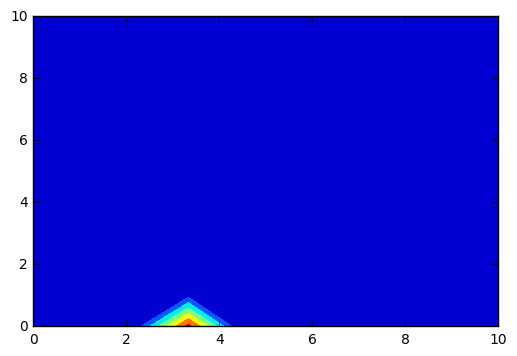

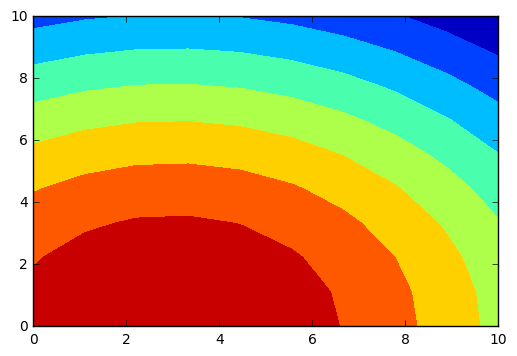

In [14]:
# phi = lambda x: [1,x,x**2]

def prior(w, C, mean=[0.0, 3.0, 0.0]):
    assert w.ndim == 2
    
    sigma = np.zeros(shape=(w.shape[1], w.shape[1]))
    sigma[0,0] = 200 # Bias slabo zregularyzowany
    # Mozna ladniej zapisac
    for id in range(1, w.shape[1]):
        sigma[id, id] = C # Duze C -> malo zregularyzowany
    return scipy.stats.multivariate_normal.pdf(w,mean,sigma)

def prior_plt(C):
    N=10
    x = np.linspace(0, 10, N)
    y = np.linspace(0, 10, N)
    xv, yv = np.meshgrid(x, y)
    w = np.array([[0.88,xv[i,j], yv[i,j]] for i in range(N) for j in range(N)])
    res = prior(w,C)
    plt.contourf(x,y,res.reshape((10,10)))
    plt.show()

prior_plt(0.1)
prior_plt(100)


In [23]:
def loglikelihood(w, X, Y, phi=lambda x: [1, x], sigma=1.0):
    phi_X = np.array([phi(x) for x in X])
    print phi_X.shape, w.shape, Y.shape
    means = np.dot(phi_X, w)
    res = sum([scipy.stats.multivariate_normal.pdf(t[i],means[i],sigma) for i in range(len(means))])
    return res
def logplot():
    N=10
    x = np.linspace(0, 10, N)
    y = np.linspace(0, 10, N)
    xv, yv = np.meshgrid(x, y)
    w = np.array([[xv[i,j], yv[i,j]] for i in range(N) for j in range(N)])
    res = []
    for wi in w:
        res.append(loglikelihood(w, domain, t))
    res = np.array(res)
    plt.contourf(x,y,res.reshape((10,10)))
    plt.show()
logplot()

(101, 2) (100, 2) (101,)


ValueError: shapes (101,2) and (100,2) not aligned: 2 (dim 1) != 100 (dim 0)

# Ewaluacja

Cały problem w uczeniu maszynowym polega na tym, że nie znamy danych testujących, tj. danych na których nasz model będzie używany.

Na potrzeby tych ćwiczeń załóżmy że nasz model będzie aplikowany na danych pochodzących z tego samego rozkładu co zbiór który dostaliśmy. Aby *zasymulować* tą sytuację, dzielimy zbiór na zbiór trenujący i testujący *zupełnie losowo*.

<img src="figures/L3/K-fold_cross_validation_EN.jpg">

## Cwiczenie 3 (3 pkt) - MAP oraz co to znaczy dobra regularyzacja?

W tym ćwiczeniu Twoim zadaniem jest stworzenie klasy ToyBayesianLinearRegression, która nauczy model bayesowskiej regresji liniowej z wykorzystaniem liczenia bezposrednio wzoru na posterior.

Niech $phi(x) = [1, x, x^2]$, niech $sigma=1.0$

1. Podziel zbiór domain na zbiór trenujący i testujący uzywajac: ``X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=1)``

2. Zmodyfikuj ToyLinearRegression aby używał wzorów na MAP [źródło: Bishop, albo http://kudkudak.github.io/assets/pdf/talks/gp.pdf]

3. Policz wynik na zbiorze tesującym modelu nauczonego na zbiorze trenującym z C=0.1 oraz C=100

4. Które C jest lepsze i dlaczego? Upewnij się, że Twój argument uwzględnia to jaki jest *prawdziwy* model danych.

Hint: Wersja Bayesowska sprowadza się do *bardzo prostej modyfikacji ćw 1*

In [23]:
class ToyBayesianLinearRegression:
    def __init__(self, phi, C):
        self.C = C
        self.phi = phi
    def fit(self,X, y):
        X = np.array([self.phi(x) for x in X])
        L = np.zeros((3,3))
        L[0,0] = 0
        for i in range(1,3):
            L[i,i] = 1/float(self.C)
        self.w = np.dot(np.linalg.inv(np.dot(X.T,X)+L),np.dot(X.T, y))
        return self

# 1. Maaala regularyzacja -> to samo co cw. 1. Polecam sprawdzic ze tak wychodzi w cw. 1 przy danym tutaj phi
w_pred = ToyBayesianLinearRegression(C=1000000, phi=lambda x: [1, x, x**2]).fit(domain, t).w

assert np.abs(w_pred - np.array([1.37, 1.475, 3.023])).max() < 0.05

# 2. Duza regularyzacja -> zabija obydwa
w_pred = ToyBayesianLinearRegression(C=0.01, phi=lambda x: [1, x, x**2]).fit(domain, t).w
assert np.abs(w_pred - np.array([2.832, 0.3217, 0.33])).max() < 0.05

# 3. Mala regularyzacja
w_pred = ToyBayesianLinearRegression(C=1, phi=lambda x: [1, x, x**2]).fit(domain, t).w
assert np.abs(w_pred - np.array([1.376, 1.944, 2.322])).max() < 0.05